In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import poke.thinfilms
reload(poke.thinfilms)
from poke.thinfilms import compute_thin_films_broadcasted,compute_thin_films_macleod
plt.style.use('bmh')
from poke.polarization import JonesToMueller

# Designing Quarter-wave stacks for high reflectance

The phase thickness of a thin film is given by
$$\Beta = \frac{2\pi n d cos(\theta)}{\lambda}$$

For the condition $\Beta = \frac{m\pi}{4}$, we can design half-wave and quarter-wave stacks. Half wave stacks are where $m$ is even, quarter wave stacks are when $m$ is odd. At normal incidence for $m=1$, we get the following solution to film thickness:

$$\frac{m\pi}{4} = \frac{2\pi n d}{\lambda}$$
$$d = \frac{m\lambda}{8n}$$


In [3]:
# set up physical parameters
wavelength = np.arange(0.35,1.1,0.005) # um
design_wavelength = 0.5 #(wavelengths[-1]+wavelengths[0])/2
aoi = 0 # deg
m = 1 # 1 = quarter wave, 2 = half wave, etc
layers = 10
factor = 1

# pick two materials 
pth_to_materials = '/Users/jashcraft/Desktop/poke/material_data/'
HfO2 = np.genfromtxt(pth_to_materials+'Kuhaili_HfO2.csv',delimiter=',',skip_header=1)
nf_SiO2 = np.genfromtxt(pth_to_materials+'Gao_SiO2.csv',delimiter=',',skip_header=1)[:500]
kf_SiO2 = np.genfromtxt(pth_to_materials+'Gao_SiO2.csv',delimiter=',',skip_header=1)[502:]
MgF2 = np.genfromtxt(pth_to_materials+'Rodriguez-de Marcos_MgF2.csv',delimiter=',',skip_header=1)[:950]
CaF2 = np.genfromtxt(pth_to_materials+'Daimon_CaF2.csv',delimiter=',',skip_header=1)
nf_Ta2O5 = np.genfromtxt(pth_to_materials+'Gao_Ta2O5.csv',delimiter=',',skip_header=1)[:726]
kf_Ta2O5 = np.genfromtxt(pth_to_materials+'Gao_Ta2O5.csv',delimiter=',',skip_header=1)[728:]
print(kf_SiO2[0])

# create splines
from scipy.interpolate import interp1d
n_HfO2 = interp1d(HfO2[...,0],HfO2[...,1],kind='cubic')
np_SiO2 = interp1d(nf_SiO2[...,0],nf_SiO2[...,1],kind='cubic')
kp_SiO2 = interp1d(kf_SiO2[...,0],kf_SiO2[...,1],kind='cubic')
n_SiO2 = lambda wave: np_SiO2(wave) + 1j*kp_SiO2(wave)
n_MgF2 = interp1d(MgF2[...,0],MgF2[...,1],kind='cubic')
n_CaF2 = interp1d(CaF2[...,0],CaF2[...,1],kind='cubic')
np_Ta2O5 = interp1d(nf_Ta2O5[...,0],nf_Ta2O5[...,1],kind='cubic')
kp_Ta2O5 = interp1d(kf_Ta2O5[...,0],kf_Ta2O5[...,1],kind='cubic')
n_Ta2O5 = lambda wave: np_Ta2O5(wave) + 1j*kp_Ta2O5(wave)

print(r'$\Delta g$'+' at design wavelength')
print(f'= {2/np.pi * np.arcsin((n_HfO2(design_wavelength) - n_SiO2(design_wavelength)))/(n_HfO2(design_wavelength) + n_SiO2(design_wavelength))}')

# set up the stack
stack = []
aoi = np.full_like(wavelength,np.radians(aoi),dtype=np.complex128)
# we want alternative quarter wave layers
d_HfO2 = m*design_wavelength/(np.cos(aoi)*4*n_HfO2(wavelength))
d_SiO2 = m*design_wavelength/(np.cos(aoi)*4*n_SiO2(wavelength))
d_MgF2 = m*design_wavelength/(np.cos(aoi)*4*n_MgF2(wavelength))
d_Ta2O5 = m*design_wavelength/(np.cos(aoi)*4*n_Ta2O5(wavelength))

for i in range(layers):
    # stack.append((n_MgF2(wavelength),d_MgF2/2))
    # stack.append((n_HfO2(wavelength),d_HfO2/2))
    # stack.append((n_Ta2O5(wavelength),d_Ta2O5/2))
    stack.append((n_Ta2O5(wavelength),np.full_like(aoi,d_Ta2O5/2)))
    stack.append((n_SiO2(wavelength),np.full_like(aoi,d_SiO2)))
    stack.append((n_Ta2O5(wavelength),np.full_like(aoi,d_Ta2O5/2)))
    # stack.append((n_MgF2(wavelength),np.full_like(aoi,d_MgF2/2)))
    # stack.append((n_MgF2(wavelength),d_HfO2/2))

stack.append((n_SiO2(wavelength))) # need to add the substrate
    
# now get the films
# rs = compute_thin_films_macleod(stack,np.radians(aoi),wavelength,polarization='s',substrate_index=n_SiO2(wavelength))
# rp = compute_thin_films_macleod(stack,np.radians(aoi),wavelength,polarization='p',substrate_index=n_SiO2(wavelength))
# power_new = ((np.abs(rs)**2 + np.abs(rp)**2)/2)
rs,ts = compute_thin_films_broadcasted(stack,aoi,wavelength,polarization='s',substrate_index=n_SiO2(wavelength))
rp,tp = compute_thin_films_broadcasted(stack,aoi,wavelength,polarization='p',substrate_index=n_SiO2(wavelength))
power = ((np.abs(rs)**2 + np.abs(rp)**2)/2)
trans = ((np.abs(ts)**2 + np.abs(tp)**2)/2)

[0.254    0.001171]
$\Delta g$ at design wavelength
= (0.08298797484538555+0j)


ValueError: A value (0.35) in x_new is below the interpolation range's minimum value (0.352).

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


ValueError: A value (0.35) in x_new is below the interpolation range's minimum value (0.352).

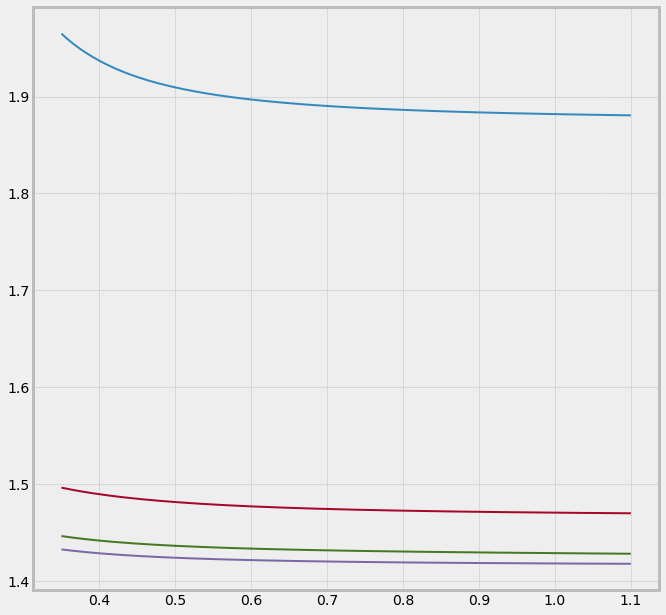

In [261]:
plt.figure(figsize=[10,10])
plt.plot(wavelength,n_HfO2(wavelength),label='HfO2')
plt.plot(wavelength,n_SiO2(wavelength),label='SiO2')
plt.plot(wavelength,n_MgF2(wavelength),label='MgF2')
plt.plot(wavelength,n_CaF2(wavelength),label='CaF2')
plt.plot(wavelength,n_Ta2O5(wavelength),label='Ta2O5')
plt.legend()
# plt.ylim([1,2.1])
plt.show()

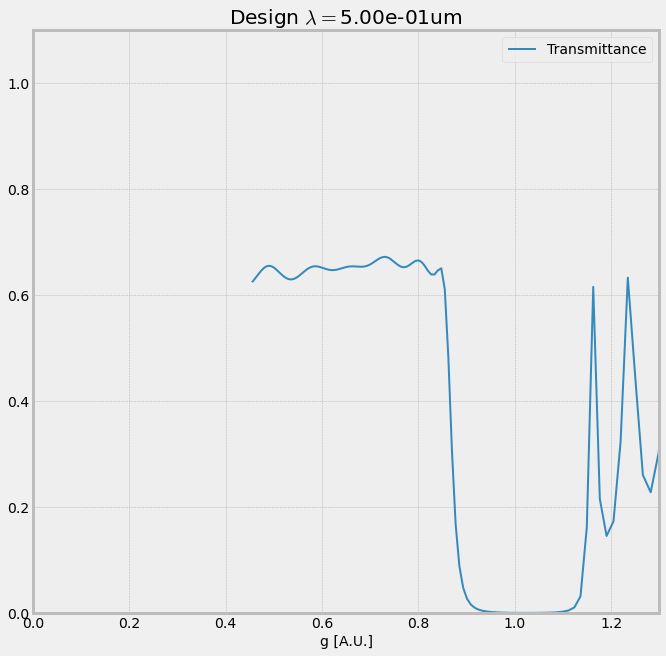

In [259]:
g = design_wavelength/wavelength
plt.figure(figsize=[10,10])
plt.title('Design '+r'$\lambda = $'+f'{design_wavelength:.2e}um')
# plt.plot(g,power,label='Reflectance')
plt.plot(g,trans,label='Transmittance')
# plt.plot(g,[1-R-T for R,T in zip(power,trans)],label='Absorbance')
plt.legend()
plt.ylim([0,1.1])
plt.xlim([0,1.3])
plt.xlabel('g [A.U.]')
plt.ylabel('')
plt.show()

In [264]:
which = int(len(rs)/2)
matrix = np.array([[rs[which],0],
                   [0,rp[which]]])

print(JonesToMueller(matrix))

[[0.03536413 0.         0.         0.        ]
 [0.         0.03536413 0.         0.        ]
 [0.         0.         0.03536413 0.        ]
 [0.         0.         0.         0.03536413]]
